# Frequent Itemset Mining: Apriori Alternatives

In Module 3, we explored **apriori** method for mining frequent itemsets and inferring association rules. The key advantage of applying the apriori principle is that this method prunes a good amount of infrequent itemsets and rules. It is the first association rule mining algorithm that uses support-based pruning to systematically control the exponential growth of candidate itemsets.

**Apriori principle:** If an itemset is frequent, then all of its subsets must also be frequent. In other words, if an itemset is infrequent, then its supersets cannot be frequent. 

Despite its significant performance improvement, the apriori algorithm still incurs considerable I/O overhead since it requires making several passes over the transaction data set. E.g., let's think that the transaction database is a PostgreSQL database, and scanning a database is a costly operation. Several alternative methods have been developed to overcome these limitations and improve the efficiency of the apriori algorithm. In this notebook, we will explore **FP-Growth**. Also, we will explore **maximal frequent itemsets**, a compact representation for frequent itemsets. 

## Frequent Pattern Growth (FP-Growth)

This section presents an alternative algorithm called FP-growth that takes a different approach to indetifying frequent itemsets. Like the apriori method, this algorithm does not generate and test frequent itemsets. Instead, it encodes the dataset using a compact data structure called a frequent pattern tree (FP-tree) and extracts frequent itemsets directly from this structure. 

<img src="../images/fp-growth.png" height=400 width=600 />

*Fig. Frequent pattern growth method. The tree express the entire dataset as a compact representation. Here null is the root. We can traverse this tree from the root and identify frequent itemsets.*

The above fig shows a dataset that contains ten transactions and five items. Initially, the FP-tree contains only the root node represented by the null symbol. This fig shows the state of the tree after reading the first three and last transactions. Each node in the tree contains the label of an item and its count. The FP-tree is created by scanning the database twice. 

1. The data set is scanned once to determine the support count of each item. Infrequent items are discarded, while the frequent items are sorted in decreasing support counts 
2. Every transaction of the dataset is mapped onto one of the paths given in the FP-tree.

For this module we will be using [mlxtend](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/) python package to demonstrate frequent pattern mining and association rule mining. In this notebook we explore a copmputer sales data, a toy one. 

 ## Import required Libraries

In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth, fpmax
import matplotlib.pyplot as plt
from fim import eclat
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

## Data Loading

The data is located here: `/dsa/data/DSA-8410/association-mining/computer-sales.csv`


In [2]:
df = pd.read_csv('/dsa/data/DSA-8410/association-mining/computer-sales.csv') 
df.head()

,age,income,student,credit_rating,buys_computer
0,Youth,high,no,fair,no
1,Youth,high,no,excellent,no
2,middle,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes


In [3]:
print(f"Num of transactions = {df.shape[0]}")
print(f"Maximum num of items per transaction = {df.shape[1]}")

Num of transactions = 28
Maximum num of items per transaction = 5


## Preprocessing 

To apply `apriori`, `fpgrowth`, and other frequent pattern methods, we need to convert the dataset to a binary incidence matrix. We can use pandas `get_dummies` method for this conversion.

In [4]:
df = pd.get_dummies(df)

In [5]:
df.head()

,age_Youth,age_middle,age_senior,income_high,income_low,income_medium,student_no,student_yes,credit_rating_excellent,credit_rating_fair,buys_computer_no,buys_computer_yes
0,1,0,0,1,0,0,1,0,0,1,1,0
1,1,0,0,1,0,0,1,0,1,0,1,0
2,0,1,0,1,0,0,1,0,0,1,0,1
3,0,0,1,0,0,1,1,0,0,1,0,1
4,0,0,1,0,1,0,0,1,0,1,0,1


## A. Frequent Patterns with Apriori Method

Apriori module from mlxtend library provides fast and efficient apriori implementation.

```
Default Parameters: apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0, low_memory=False)"
```


In [6]:
freq_items = apriori(df, min_support=0.2, use_colnames=True, verbose=1)
freq_items.shape

Processing 4 combinations | Sampling itemset size 4


(42, 2)

In [7]:
freq_items.head()

,support,itemsets
0,0.357143,(age_Youth)
1,0.285714,(age_middle)
2,0.357143,(age_senior)
3,0.285714,(income_high)
4,0.285714,(income_low)


For readability, let's swap the two columns. 

In [8]:
freq_items = freq_items.reindex(columns=['itemsets', 'support'])
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))

In [9]:
print(f"Total number of frequent itemsets = {freq_items.shape[0]}")
freq_items.tail()

Total number of frequent itemsets = 42


,itemsets,support,length
37,"(credit_rating_fair, buys_computer_yes)",0.428571,2
38,"(student_no, buys_computer_no, age_Youth)",0.214286,3
39,"(credit_rating_fair, age_senior, buys_computer...",0.214286,3
40,"(income_low, student_yes, buys_computer_yes)",0.214286,3
41,"(credit_rating_fair, student_yes, buys_compute...",0.285714,3


### Rules from Frequent Itemsets

Once the frequent itemsets from transactions in a database have been found, it is straightforward to generate strong association rules from them (where strong association rules satisfy both minimum support and minimum confidence). This can be done using  confidence, which we show again here for completeness:

$\text{conf}(X \Rightarrow Y ) = P(Y|X) = \frac{\text{sup}(X \cup Y )}{\text{sup}(X)} = \frac{\text{count}(X \cup Y )}{\text{count}(X)}$. 


We now apply `association_rules` on the frequent itemsets found in the earlier step. The function definition is as follows: 

```
association_rules(df, metric=’confidence’, min_threshold=0.8, support_only=False)
```

Metric can be set to `confidence`, `lift`, `support`, `leverage` and `conviction`.

In [10]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.75)
print(f"Total number of rules = {rules.shape[0]}")
rules.head()

Total number of rules = 17


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(age_middle),(buys_computer_yes),0.285714,0.642857,0.285714,1.00,1.555556,0.102041,inf
1,(income_high),(student_no),0.285714,0.500000,0.214286,0.75,1.500000,0.071429,2.000000
2,(income_high),(credit_rating_fair),0.285714,0.571429,0.214286,0.75,1.312500,0.051020,1.714286
3,(income_low),(student_yes),0.285714,0.500000,0.285714,1.00,2.000000,0.142857,inf
4,(income_low),(buys_computer_yes),0.285714,0.642857,0.214286,0.75,1.166667,0.030612,1.428571


Based on the given measures such as supports, confidence, lift, leverage, and conviction, we can subset rules and inspect them. E.g, let's see the rules that has occured at least 20% of the time with at least 80% of confidence. 


In [11]:
rules[(rules['support'] >= .20) & (rules['confidence'] >= .80)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(age_middle),(buys_computer_yes),0.285714,0.642857,0.285714,1.000000,1.555556,0.102041,inf
3,(income_low),(student_yes),0.285714,0.500000,0.285714,1.000000,2.000000,0.142857,inf
6,(student_yes),(buys_computer_yes),0.500000,0.642857,0.428571,0.857143,1.333333,0.107143,2.5
9,"(student_no, age_Youth)",(buys_computer_no),0.214286,0.357143,0.214286,1.000000,2.800000,0.137755,inf
10,"(buys_computer_no, age_Youth)",(student_no),0.214286,0.500000,0.214286,1.000000,2.000000,0.107143,inf
11,"(credit_rating_fair, age_senior)",(buys_computer_yes),0.214286,0.642857,0.214286,1.000000,1.555556,0.076531,inf
12,"(age_senior, buys_computer_yes)",(credit_rating_fair),0.214286,0.571429,0.214286,1.000000,1.750000,0.091837,inf
14,"(income_low, buys_computer_yes)",(student_yes),0.214286,0.500000,0.214286,1.000000,2.000000,0.107143,inf
16,"(credit_rating_fair, student_yes)",(buys_computer_yes),0.285714,0.642857,0.285714,1.000000,1.555556,0.102041,inf


We can see all but one rules have the highest confidence and coviction. We should not take this result seriously as there are only 28 transactions. Let's explore some surprising patterns with lift and leverage. 

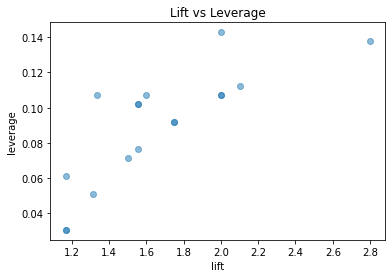

In [12]:
plt.scatter(rules['lift'], rules['leverage'], alpha=0.5)
plt.xlabel('lift')
plt.ylabel('leverage')
plt.title('Lift vs Leverage');
plt.show()

In [13]:
rules[(rules['lift'] >= 2) & (rules['leverage'] >= .10)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(income_low),(student_yes),0.285714,0.500000,0.285714,1.00,2.0,0.142857,inf
8,"(student_no, buys_computer_no)",(age_Youth),0.285714,0.357143,0.214286,0.75,2.1,0.112245,2.571429
9,"(student_no, age_Youth)",(buys_computer_no),0.214286,0.357143,0.214286,1.00,2.8,0.137755,inf
10,"(buys_computer_no, age_Youth)",(student_no),0.214286,0.500000,0.214286,1.00,2.0,0.107143,inf
14,"(income_low, buys_computer_yes)",(student_yes),0.214286,0.500000,0.214286,1.00,2.0,0.107143,inf


Now, we will explore the FP-Growth method, which does not employ candidate generation and testing strategy. Instead, this method infers a compact tree (aka FP tree) representation of the entire dataset and provides rules by traversing this dataset. This method usually runs much faster than the apriori method. 

## B. Frequent Patterns with FP-Growth



In [14]:
freq_items_fp = fpgrowth(df, min_support=0.2, use_colnames=True)

# swap columns for readability 
freq_items_fp = freq_items_fp.reindex(columns=['itemsets', 'support'])
freq_items_fp['length'] = freq_items_fp['itemsets'].apply(lambda x: len(x))

In [15]:
print(f"Total number of frequent itemsets = {freq_items_fp.shape[0]}")
freq_items_fp.tail()

Total number of frequent itemsets = 42


,itemsets,support,length
37,"(credit_rating_fair, student_yes)",0.285714,2
38,"(credit_rating_fair, student_yes, buys_compute...",0.285714,3
39,"(income_low, student_yes)",0.285714,2
40,"(income_low, buys_computer_yes)",0.214286,2
41,"(income_low, student_yes, buys_computer_yes)",0.214286,3


As expected, we get the 42 frequent patterns like the apriori method. Now we can pass these frequent patterns to `association_rules` method for inferring rules. 

In [16]:
rules_fp = association_rules(freq_items_fp, metric="confidence", min_threshold=0.75)
print(f"Total number of rules = {rules_fp.shape[0]}")
rules_fp.head()

Total number of rules = 17


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(credit_rating_fair),(buys_computer_yes),0.571429,0.642857,0.428571,0.75,1.166667,0.061224,1.428571
1,(buys_computer_no),(student_no),0.357143,0.500000,0.285714,0.80,1.600000,0.107143,2.500000
2,"(student_no, buys_computer_no)",(age_Youth),0.285714,0.357143,0.214286,0.75,2.100000,0.112245,2.571429
3,"(student_no, age_Youth)",(buys_computer_no),0.214286,0.357143,0.214286,1.00,2.800000,0.137755,inf
4,"(buys_computer_no, age_Youth)",(student_no),0.214286,0.500000,0.214286,1.00,2.000000,0.107143,inf


## Apriori vs FP-Growth 

Why use FP-Growth. As FP-Growth doesn't require creating candidate sets explicitly, it can be magnitudes faster than the alternative Apriori algorithm. For instance, the following cells compare the performance of the Apriori algorithm to the performance of FP-Growth -- even in this very simple retail dataset scenario, FP-Growth is about 2 times faster.

In [17]:
## Time taken by apriori: n: inner loop; r: outer loop
%timeit -n 100 -r 10 apriori(df, min_support=0.2)



4.7 ms ± 17.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [18]:
## Time taken by FP-Growth
%timeit -n 100 -r 10 fpgrowth(df, min_support=0.2)

2.47 ms ± 32.9 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


## C. Compact Representation of Frequent Itemsets

In a real-world scenario, the number of frequent itemsets produced could be very large. It is useful to identify a small representative set of itemsets from which all other frequent itemsets can be derived. Two such representations are **maximal** and **closed** frequent itemsets. 

### Maximal Frequent Itemsets

A **maximal frequent itemset** is defined as a frequent itemset for which none of its immediate supersets are frequent. Maximal frequent itemsets effectively provide a compact representation of frequent itemsets. We can derive all frequent itemsets from a maximal frequent itemsets. 



<img src="../images/maximal-itemset.png" height=400, width=600 />

**Fig. Maximal frequent itemset.** _This figure shows the lattice of itemsets for five items {a, b, c, d, e}. In this toy example the boundary between frequent and infrequent itemsets are shown. An itemset such as {a,d} is maximal frequent because all of its immediate supersets, {a,b,d}, {a,c,d}, and {a,d,e}, are infrequent. In contrast, {a,c} is non-maximal becauseone of its immediate supersets, {a,c,e}, is frequent. (source: Intro to Data Mining byTan et al.)_

The sizeof an FP-tree is typically smaller than the size of the uncompressed data because many transactions in market basket data often share a few items in common.

### Closed Frequent Itemsets

An **closed itemset** is the one for which none of its immediate supersets has the same support count as the itemset. In other words, an itemsetset X is not closed if at least one of its immediate supersets has the same support count as X. 

An itemset is a **closed frequent itemset** if it is closed and its support is greater than or equal to user-defined minimum support.

<img src="../images/closed-itemset.png" height=400 width = 600 />

**Fig. Example of closed frequent itemsets.** _As the node { b, c }  is associated with transaction ids 1, 2, and 3, its support count is equal to three. From the transactions given in this diagram, notice that every transaction that contains b also contains c. Consequently,the support for {b} is identical to {b, c} and {b} should not be considered a closed itemset. On the other hand, {b, c} is a closed itemset because it does not have the same support count as any of its supersets._

**Maximal frequent itemsets are subset of closed frequent itemsets.** Now, we use `fpmax` method to identify all maximal frequent patterns with min support 0.2 for this dataset.

In [19]:
max_patterns = fpmax(df, min_support=0.2, use_colnames=True)

In [20]:
# for readability 
max_patterns = max_patterns.reindex(columns=['itemsets', 'support'])
max_patterns['length'] = max_patterns['itemsets'].apply(lambda x: len(x))

In [21]:
print(f"Total number of maximal frequent patterns = {max_patterns.shape[0]}")
max_patterns

Total number of maximal frequent patterns = 20


,itemsets,support,length
0,"(buys_computer_yes, age_middle)",0.285714,2
1,"(credit_rating_fair, income_high)",0.214286,2
2,"(student_no, income_high)",0.214286,2
3,"(income_low, student_yes, buys_computer_yes)",0.214286,3
4,"(credit_rating_fair, age_Youth)",0.214286,2
5,"(student_no, buys_computer_no, age_Youth)",0.214286,3
6,"(credit_rating_fair, age_senior, buys_computer...",0.214286,3
7,"(income_medium, age_senior)",0.214286,2
8,"(age_senior, student_yes)",0.214286,2
9,"(credit_rating_excellent, buys_computer_no)",0.214286,2


There are 20 maximal frequent itemsets which are almost half of the total number (42) of frequent patterns. 

In [22]:
%timeit -n 100 -r 10 fpmax(df, min_support=0.2)

2.63 ms ± 17.1 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


The method runs as fast as the FP-Growth method. 